Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from systole.detection import oxi_peaks, rr_artefacts

sns.set_context('talk')

Remove subject

In [2]:
remove = ['sub_0037', 'sub_0075', 'sub_0106', 'sub_0126']

# Signal quality check

In [5]:
dataPath = 'C:/Users/au646069/ECG/1_VPN_aux/'
subList = os.listdir(dataPath)

check_df = pd.DataFrame([])
for subject in subList[:10]:
    if subject not in remove:
        try:
            for i in range(6):
                ppg = np.load(os.path.join(dataPath, subject, 'HBC', f'{subject[4:]}_{i}.npy'))[0]  # Load PPG signal
                signal, peaks = oxi_peaks(ppg, clean_extra=True)  # Find systolic peaks

                rr = np.diff(np.where(peaks)[0])  # Convert to RR time series
                artefacts = rr_artefacts(rr)

                for metric, value in zip(['PPG_Mean', 'PPG_std', 'nPeaks', 'nMissed', 'nExtra', 'nEctopic', 'nLong', 'nShort'], 
                                         [np.mean(ppg), np.std(ppg), sum(peaks), artefacts['missed'].sum(), artefacts['extra'].sum(), 
                                          artefacts['ectopic'].sum(), artefacts['long'].sum(), artefacts['short'].sum()]):


                    check_df = check_df.append({'Subject': subject,
                                                'Trial': i,
                                                'Metric': metric,
                                                'Value': value
                                               }, ignore_index=True)
        except:
            print(f'Subject {subject} not found.')        

Subject sub_0025 not found.


In [113]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from ecgdetectors import Detectors
from systole.utils import to_neighbour
from systole.detection import interpolate_clipping

x= ppg
sfreq=75
win=1
new_sfreq=1000
clipping=True
noise_removal=True
peak_enhancement=True
distance=0.3
clean_extra=True

"""A simple peak finder for PPG signal.

Parameters
----------
x : list or 1d array-like
    The oxi signal.
sfreq : int
    The sampling frequency. Default is set to 75 Hz.
win : int
    Window size (in seconds) used to compute the threshold.
new_sfreq : int
    If resample is *True*, the new sampling frequency.
resample : boolean
    If `True` (default), will resample the signal at *new_sfreq*. Default
    value is 1000 Hz.
peak_enhancement : boolean
    If `True` (default), the ppg signal is squared before peaks detection.
distance : float
    The minimum interval between two peaks (seconds).

Returns
-------
peaks : 1d array-like
    Numpy array containing R peak timing, in sfreq.
resampled_signal : 1d array-like
    Signal resampled to the `new_sfreq` frequency.

Notes
-----
This algorithm use a simple rolling average to detect peaks. The signal is
first resampled and a rolling average is applyed to correct high frequency
noise and clipping, using method detailled in [1]_. The signal is then
squared and detection of peaks is performed using threshold corresponding
to the moving averagte + stadard deviation.

.. warning :: This function will resample the signal to 1000 Hz by default.

Examples
--------
>>> from systole import import_ppg
>>> from systole.detection import oxi_peaks
>>> df = import_ppg()  # Import PPG recording
>>> signal, peaks = oxi_peaks(df.ppg.to_numpy())
>>> print(f'{sum(peaks)} peaks detected.')
378 peaks detected.

References
----------
.. [1] van Gent, P., Farah, H., van Nes, N. and van Arem, B., 2019.
Analysing Noisy Driver Physiology Real-Time Using Off-the-Shelf Sensors:
Heart Rate Analysis Software from the Taking the Fast Lane Project. Journal
of Open Research Software, 7(1), p.32. DOI: http://doi.org/10.5334/jors.241
"""
if isinstance(x, list):
    x = np.asarray(x)

# Interpolate
f = interp1d(np.arange(0, len(x)/sfreq, 1/sfreq),
             x,
             fill_value="extrapolate")
time = np.arange(0, len(x)/sfreq, 1/new_sfreq)
x = f(time)

# Copy resampled signal for output
resampled_signal = np.copy(x)

# Remove clipping artefacts with cubic interpolation
if clipping is True:
    x = interpolate_clipping(x)

if noise_removal is True:
    # Moving average (high frequency noise + clipping)
    rollingNoise = int(new_sfreq*.05)  # 0.05 second window
    x = pd.DataFrame(
        {'signal': x}).rolling(rollingNoise,
                               center=True).mean().signal.to_numpy()
if peak_enhancement is True:
    # Square signal (peak enhancement)
    x = x ** 2

# Compute moving average and standard deviation
signal = pd.DataFrame({'signal': x})
mean_signal = signal.rolling(int(new_sfreq*0.75),
                             center=True).mean().signal.to_numpy()
std_signal = signal.rolling(int(new_sfreq*0.75),
                            center=True).std().signal.to_numpy()

# Substract moving average + standard deviation
x -= (mean_signal + std_signal)

# Find positive peaks
peaks_idx = find_peaks(x, height=0, distance=int(new_sfreq*distance))[0]

# Create boolean vector
peaks = np.zeros(len(x), dtype=bool)
peaks[peaks_idx] = 1

# Remove extra peaks
if clean_extra:
    
    # Search artefacts
    rr = np.diff(np.where(peaks)[0])  # Convert to RR time series
    artefacts = rr_artefacts(rr)
    
    # Clean peak vector
    peaks[peaks_idx[1:][artefacts['extra']]] = 0

In [102]:
# Search artefacts
rr = np.diff(np.where(peaks)[0])  # Convert to RR time series
artefacts = rr_artefacts(rr)

(0.0, 10000.0)

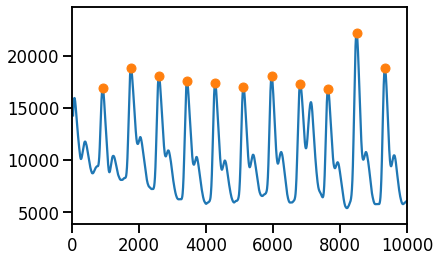

In [115]:
plt.plot(signal)
plt.plot(np.arange(0, len(signal))[peaks], signal[peaks], 'o')
plt.xlim(0, 10000)

(0.0, 10000.0)

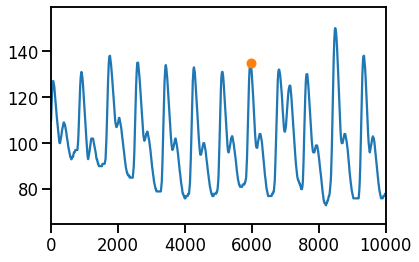

In [100]:
# Find valley index
valley_idx = find_peaks(-x, height=0, distance=int(new_sfreq*distance))[0]

# Keep only the closest previous valley
valley_idx = [valley_idx[np.where(np.array(valley_idx)<p)[0][-1]] for p in peaks_idx if np.where(np.array(valley_idx)<p)[0].any()]

# Compute valley to peak amplitude
valley2peak = [x[peaks_idx[peaks_idx>valley_idx[i]][0]] - x[valley_idx[i]] for i in range(len(valley_idx))]

# Get ratio of consecutive values
ratio = np.sqrt(valley2peak)[:-1]/np.sqrt(valley2peak)[1:]

plt.plot(signal)
#plt.plot(np.arange(0, len(signal))[valley_idx], signal[valley_idx], 'o')
plt.plot(peaks_idx[np.where(ratio>1.2)[0]], signal[peaks_idx[np.where(ratio>1.2)[0]]], 'o')
plt.xlim(0, 10000)

In [101]:
# Find abnormal amplitudes
peaks_idx[np.where(ratio>1.2)[0]+2]

array([7137], dtype=int64)

In [87]:
peaks_idx[peaks_idx>valley_idx[i]][0]

5957

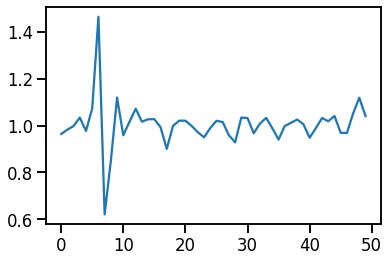

In [93]:
plt.plot()

In [73]:
x[peaks_idx[i]]

3690.9899367479666

In [62]:
%%timeit
[valley_idx[np.where(np.array(valley_idx)<p)[0][-1]] for p in peaks_idx if np.where(np.array(valley_idx)<p)[0].any()]        

437 µs ± 20.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


(0.0, 10000.0)

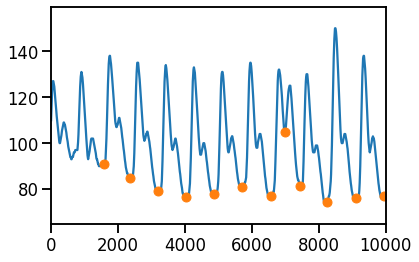

In [63]:


plt.plot(signal)
plt.plot(np.arange(0, len(signal))[valley_idx], signal[valley_idx], 'o')
plt.xlim(0, 10000)

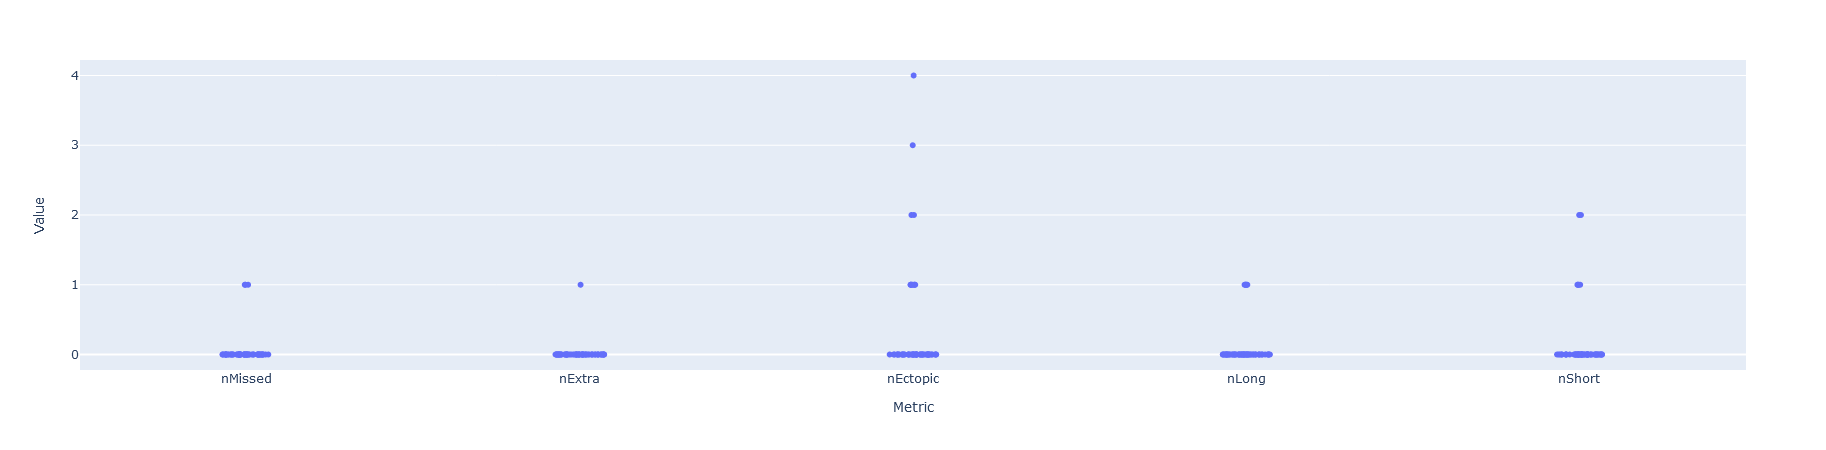

In [6]:
fig = px.strip(check_df[check_df.Metric.isin(['nMissed', 'nExtra', 'nEctopic', 'nLong', 'nShort'])], 
               y="Value", x='Metric', hover_data=['Subject', 'Trial'])
fig.show()

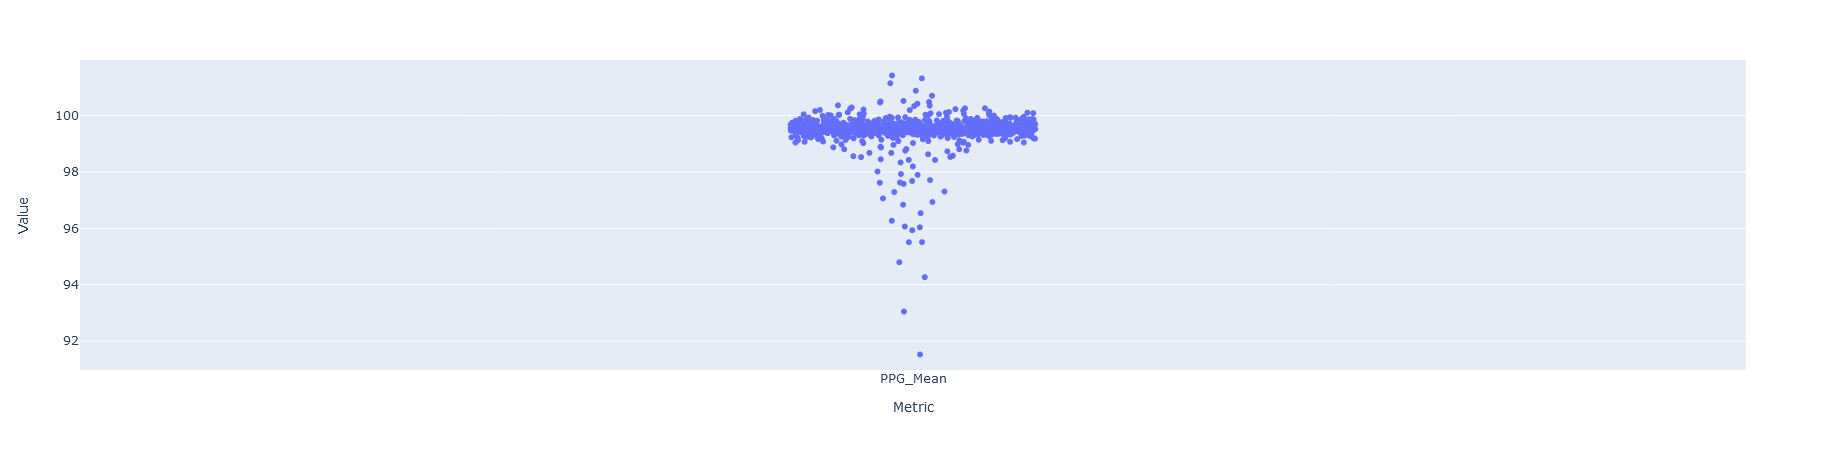

In [5]:
fig = px.strip(check_df[check_df.Metric.isin(['PPG_Mean'])], 
               y="Value", x='Metric', hover_data=['Subject', 'Trial'])
fig.show()

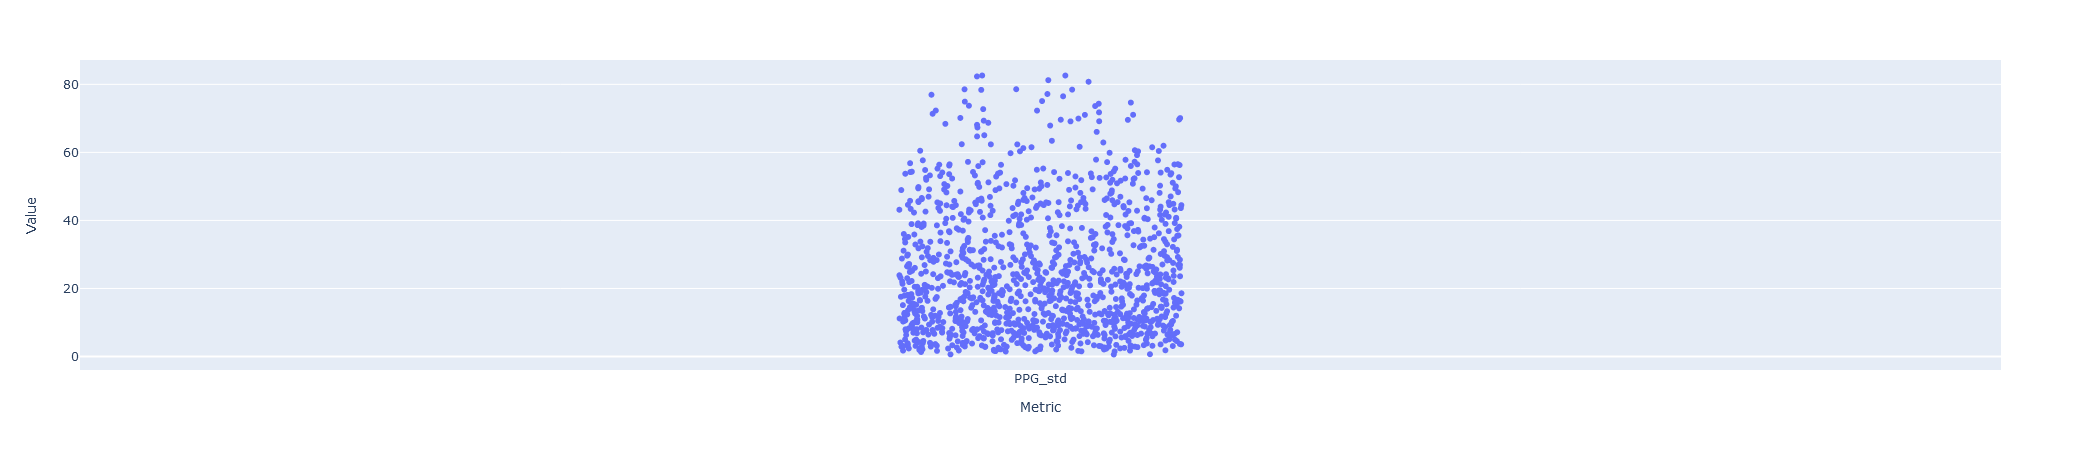

In [6]:
fig = px.strip(check_df[check_df.Metric.isin(['PPG_std'])], 
               y="Value", x='Metric', hover_data=['Subject', 'Trial'])
fig.show()